In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import markdown
import math
import requests
import io

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.





# How many people in Ontario have COVID?
## Fermi-style Q/A 

This is the conversation at home:

Wife: What are you doing.

Me: COVID

Wife: <Sigh, not again.> What are you looking at?

Me: Data

Wife: So how many people have it?

Me: I don't know. But it is everywhere...

Wife: What does that mean?

Me: ...



We know how many patients have been tested from publicly available data, but how many people actually have it? What does that even mean? We know the test is not perfect (https://www.medrxiv.org/content/10.1101/2020.04.07.20051474v1), we are undertesting and there is asympatic spread (https://www.nejm.org/doi/full/10.1056/NEJMc2001468). There are local anectodes of unexplained spread and negative tests. But what does this mean?

This notebook explores the question and answers visually.

First, how does the virus work. We know it spreads from person to person, lying dormant in ones nasopharynx for a median of 5.1 days before symptoms occur (https://annals.org/AIM/FULLARTICLE/2762808/INCUBATION-PERIOD-CORONAVIRUS-DISEASE-2019-COVID-19-FROM-PUBLICLY-REPORTED). 



## Mild Symptoms

We also know that symptoms vary markedly. Some patients are asymptomatic and others have mild symptoms, for which they would not seek medical testing or treatment.

From a review of a large Wuhan case series in a JAMA paper (https://jamanetwork.com/journals/jama/fullarticle/2762130), we have an idea of the distribution of disease severity.

Spectrum of disease (N = 44 415)

Mild: 81% (36 160 cases)

Severe: 14% (6168 cases)

Critical: 5% (2087 cases)


In [ ]:
mild = 0.81

**Point 1:** 4/5 of cases are mild. Are we testing these? We will discuss below. But first...

## Aymptomatic Patients

Asymptomatic spread is now well-documented, with a summary of recent evidence here: https://www.cebm.net/covid-19/covid-19-what-proportion-are-asymptomatic/. The range in the literature is 5-80%.

One studies estimated the number of infected patients who are never tested (unascertained) from fitting SEIR-type model including unascertained cases to Wuhan data (https://www.medrxiv.org/content/10.1101/2020.03.03.20030593v1):

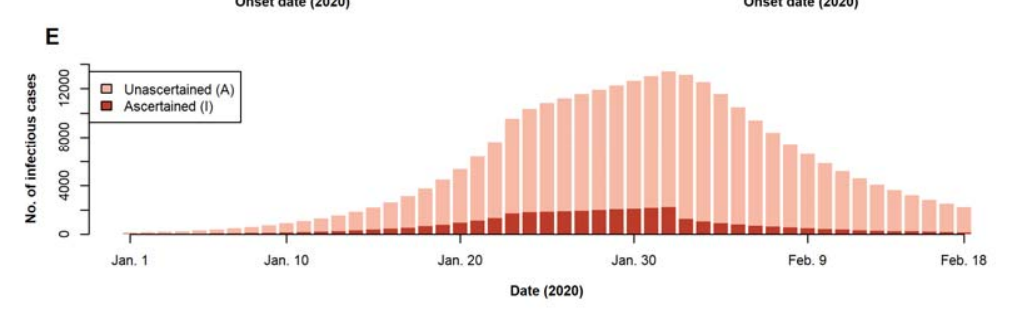

Using their modeling, during the early growth phase of the disease, at best 37% of cases were ascertained (tested). 



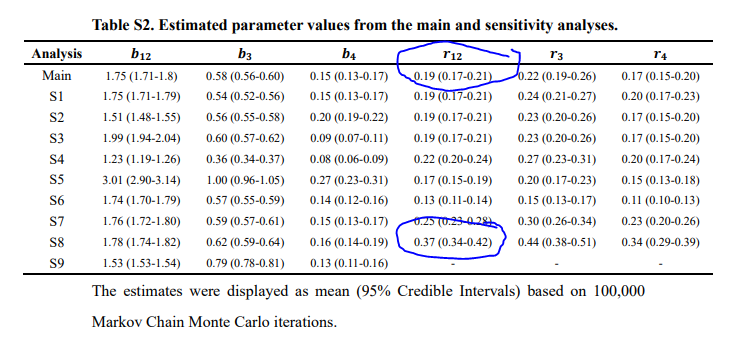

A second reasonably convincing story (because of stated impact; rigor is hard to evaluate) comes from Vo-Euganeo in Italy: a town of 300 where the **ENTIRE POPULATION** of 3000 was repeatedly tested (https://www.bmj.com/content/368/bmj.m1165). First, they noted that 50-75% of residents were asymptomatic. Second, they report that isolating all positive cases resulted in a 90% decrease in sympomatic people in 10 days.

We will take the number of asymptomatic casse to measure 60% for illustrative purposes.

In [ ]:
unascertained = 0.60
ascertained = 1-unascertained
unasc_ratio = round(unascertained / ascertained,1)
print(unascertained) 
print(unasc_ratio) 

**Point 2: While there is a range of estimates, it is reasonable to say there are 1.5 asymptomatic cases for each with symptoms.**

## How's Our (Ontario's) Testing?


Next we have to look at testing criteria. Guangdong province in China can serve as a comparison. The most popluous province in China set up fever clinics to detect spread from Hubei. A total of 320,000 tests were performed as per a WHO report. At *peak* (Jan 30, 2020), 0.47% tests were positive (0.14% overall). 
(https://www.who.int/docs/default-source/coronaviruse/who-china-joint-mission-on-covid-19-final-report.pdf)

In [ ]:
gd_pos_test_rate = 0.0047
round(1 / gd_pos_test_rate)

At minimum, 213 people were tested for each positive case in Guangdong!

So now let's compare positive test rate in Ontario. 

From Ontario's official data, we can see the % of positive tests has climbed from 0.47% to over 10% at one point!

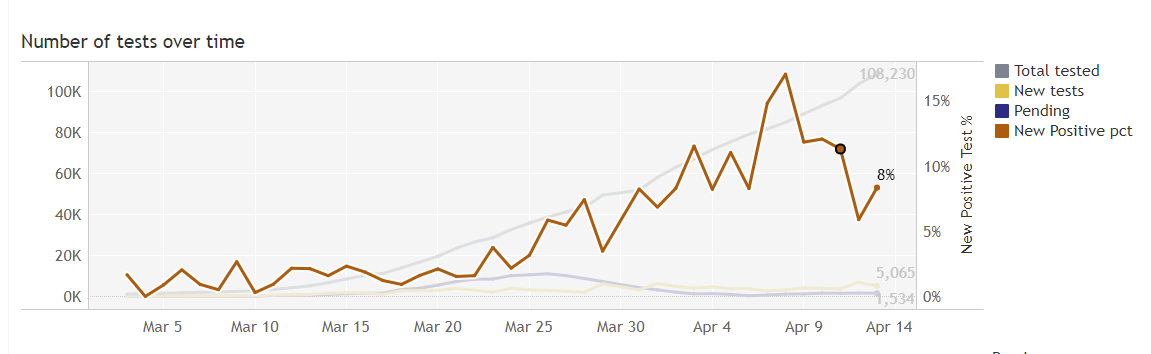

(Source: https://howsmyflattening.ca/#/analysis)


In [ ]:
# Get current positive test rate

df = pd.read_csv("/kaggle/input/test-on/test_data_on (2).csv")
current = df.tail(1)
current

In [ ]:
current_pos_test_rate = current["positive"]/current["total"]
current_pos_test_rate 

In [ ]:
pos_test_rate=current_pos_test_rate
np.round(1 / pos_test_rate)

Either the disease is truly everywhere...or we are increasingly testing fewer and fewer people. We know the latter to be true as criteria are reasonably stringent and politicians are starting to get upset (https://www.tvo.org/article/how-ontarios-covid-19-testing-debacle-has-cost-lives)

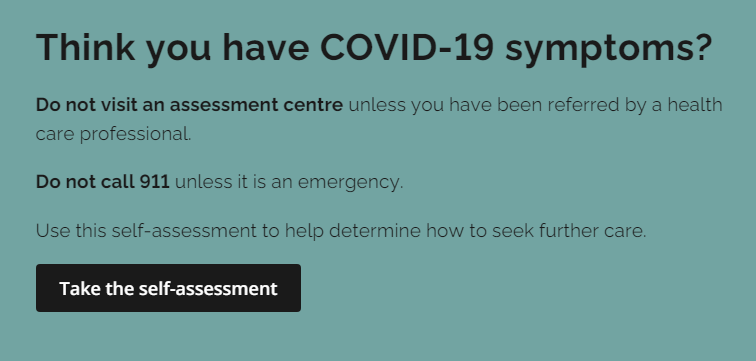

Ok. So now we can run a comparison of Ontario vs Guangdon testing rates...


Our most recent number of positive tests is below:






In [ ]:
current["positive"]

If we were testing expecting the same rate as Guangdon (0.47%), we would expect to have tested:

In [ ]:
test_on_pos = 6237
on_test_ala_gd = test_on_pos / gd_pos_test_rate

print(round(on_test_ala_gd))

In reality, far fewer tests have been peformed:



In [ ]:
current["total"]

Doing some basic math we can figure out the "Ontario-operating-as-Guangdong to Ontario-actual" ratio

In [ ]:
test_on = current["total"]

test_ratio = on_test_ala_gd / test_on

round(test_ratio)

**Point 3: So, Ontario is undertesting 12x compared to Guangdong!!**

## What does this all mean for Ontario?

First, it is probably safe to assume that Ontario is not really testing most mildly symptomatic people (81% in Wuhan). So that means, there are likely at least  4 patients with mild symptoms who are not tested for every 1 that is tested

In [ ]:
est_mild_on = 4 * test_on_pos

est_total = test_on_pos + est_mild_on
print(est_mild_on, est_total)

**Point 3:** So that means there about 32000 Ontarians who would have tested positive, if we had been testing like China.

BUT, we also know that estimates of unascertained / ascertained cases (from above)

In [ ]:
est_total_unascertained = unasc_ratio * est_total
est_total_unascertained
total_COVID_on = est_total_unascertained + est_total
print(total_COVID_on)

**Point 4:** It would be reasonable to estimate from above that there are about 78,000 (large error bars) mild and asymptomatic patients in Ontario that have NOT BEEN TESTED 

## One other hiccup: False Negatives

This was left to the end, as it is more subtle, but has important implications.

We also know that the NP swab PCR test is not 100% sensitive. 

From a study of 213 admitted patients in Wuhan, we know that PCR samples from the nasopharynx can be negative in early 30% of patients https://www.medrxiv.org/content/10.1101/2020.02.11.20021493v2.full.pdf.

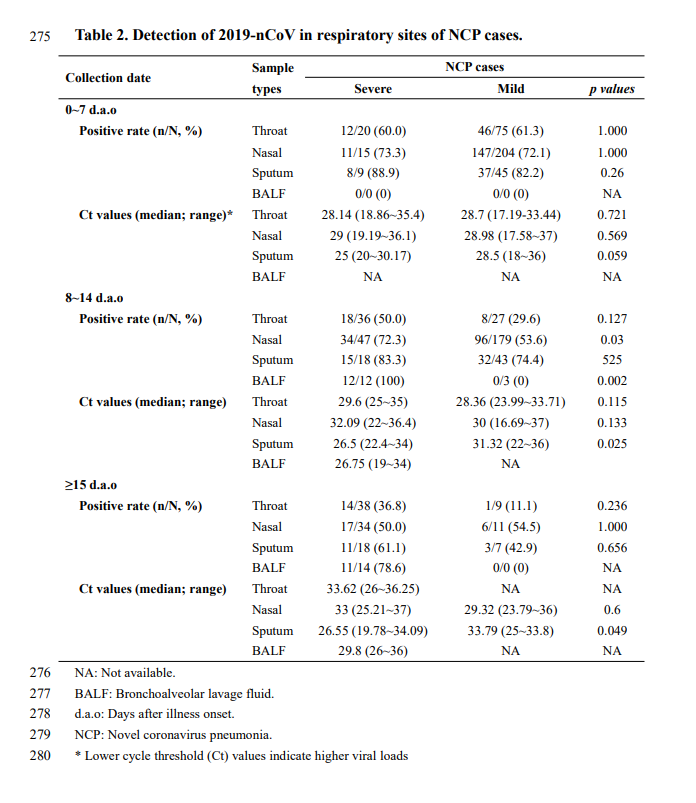

This is ballpark consistent with 1014 person study comapring CT and PCR, where 88% of patients had CT findings and only 59% had positive PCR https://pubs.rsna.org/doi/10.1148/radiol.2020200642.

Gold standard is a problem for these studies, but the imperfect sensitivity is clear. 

For Ontario, assuming a 30% FN rate...(and assuming only a single test)

In [ ]:
FN_rate = 0.3
test_on_FN = FN_rate * test_on_pos
test_on_TPFN = test_on_FN + test_on_pos
round(test_on_FN)

**Point 5:** There are likely around 1900 cases of false negative patients floating around Ontario.

In [ ]:
#Update total
total_COVID_on = est_total_unascertained + test_on_TPFN + est_mild_on
print(total_COVID_on)

In [ ]:




results = pd.DataFrame({'Number of positive tests': test_on_pos,
                        'Estimated number of patients tested but with of FN tests': test_on_FN,
                        'Estimated number of patients with mild symptoms, likely not tested' : est_mild_on,
                        'Estimated of unascertained (asymptomatic) patients': est_total_unascertained,
                       'Estimated total number of patients with COVID-19' : total_COVID_on},
                      index=[0])

#print("Summary (as of Apr 4)")
#print("Number of positive tests = ", test_on_pos)
#print("Estimated number of patients tested but with of FN tests = ", test_on_FN)
#print("Estimated number of patients with mild symptoms, likely not tested = ", est_mild_on)
#print("Estimated of unascertained (asymptomatic) patients = ", est_total_unascertained[1], "to", est_total_unascertained[0])

#number calling telehealth?

results
round(results,-2)

Let's normalize relative to positive tests so we can better appreciate what is going on here:

In [ ]:
results_norm = results.div(test_on_pos)
results_norm


#Visualization link

Data as of Apr 13, 2020

https://datastudio.google.com/u/0/reporting/1b5237ba-2533-4cf9-8dc0-b14eb45ecdef/page/iLEMB

Thanks Marc Soares!!!
https://www.linkedin.com/in/marcsoares/

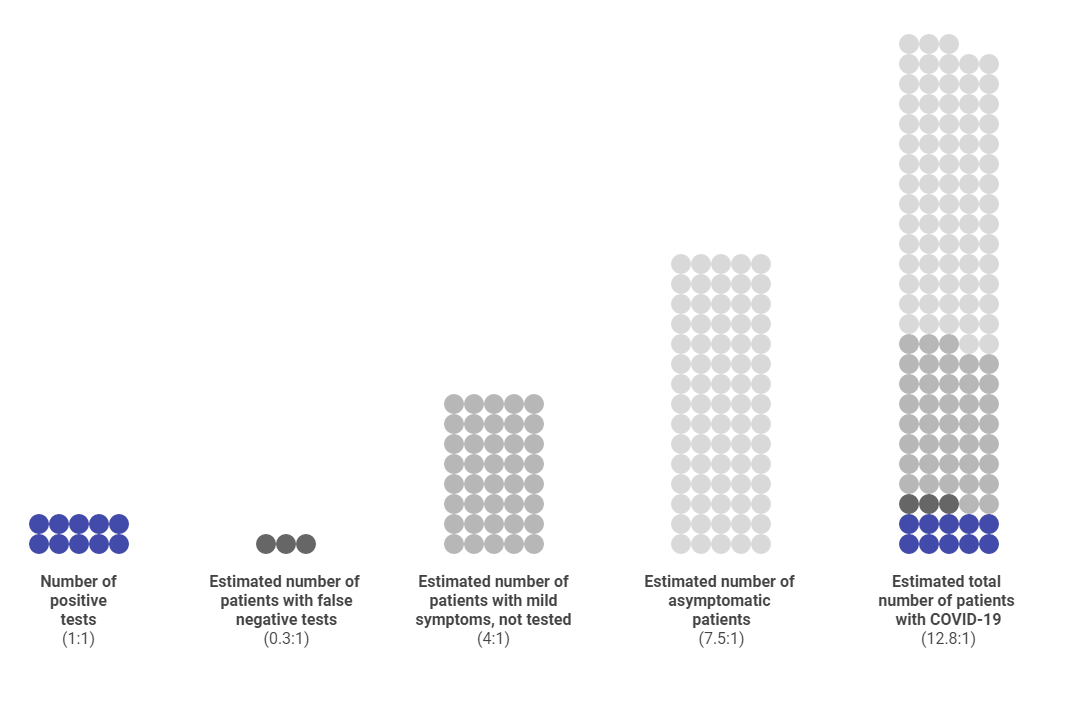


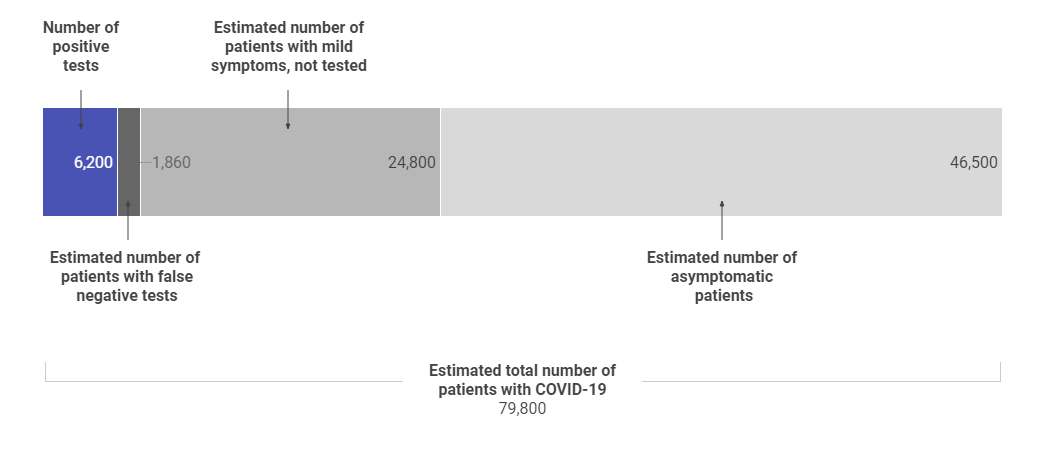

## Summary and implications

**Point 1/3:** Approx. 4/5 of cases of COVID-19 are mild. We not testing these (except maybe healthcare workers). There about 32000 Ontarians who would have tested positive to date, if we had been testing like parts of China.

**Point 2/4:** While there is a range of estimates, it is reasonable to say there are 1.5 asymptomatic cases for each case with symptoms. It would be reasonable to estimate from above that there are about 78,000 (large error bars) mild and asymptomatic patients in Ontario that have NOT BEEN TESTED

**Point 5:** There are likely around 1900 cases of false negative patients floating around Ontario.




Ontario is massively undertesting, 12x less than parts of China. We are not testing mild cases. And we know we are missing asymptomatic cases, as it true most places in the world. For each positive test in Ontario, there are likely at least 10 untested patients with COVID-19.

This is likely not a surprise to most citiziens (everyone knows someone who sounds like they had COVID but was told to stay home and self-isolate) and physicians, uncluding myself, who have seen cases that MUST be COVID but are not suspected a priori, tested or sometimes test negative (very small N).

What does this mean?

For provincial leaders:
* Get logistics in order and aggressively test and trace as Singapore, South Korea and others have shown. We currently have very little information on who HAS or HAD the disease (great discussion in Josh Gans new book: https://economics-in-the-age-of-covid-19.pubpub.org/pub/h5gzz4on). In this information poor environment, one must assume everybody has the disease. The only policy that works in that state is total lock down. If, as numbers fall, we can get into a position of information on every case, we have new policy options other than complete lock down. See Paul Romer's work re simulating different testing strategies: https://paulromer.net/
* The way to start may be to aggressively test high contact / risk people during the lock down (healthcare workers, food supply, hospital patients). This would require rapid/instant point of care testing, which is emerging.

For hospital / healthcare leaders:
* Don't trust the test alone to dictate decision-making. Asymptomatic, mildly symptomatic and false negative tests are likely entering your facilities via staff or patients. 
* Consider aggressive health care worker testing and tracing.
* Allow clinicians to isolate patients as suspected COVID even with negative testing.
* Get rapid/instant testing.

For providers
* As you probably know, this disease is everywhere in Ontario. As of this writing, testing criteria are lagging. Test and isolate if you are suspicious.
* Don't trust negative tests as providing 100% certainty. 


